In [1]:
# Sajedeh Sepehrnia & Yahya Maleki Joobani

import pickle
import numpy as np
from sklearn.cluster import KMeans
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import cv2
from matplotlib import pyplot as plt
import colorsys
from sklearn.cluster import KMeans, MeanShift, DBSCAN, AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
import math
import copy

In [2]:
def load_dataset():
  image_pickle_file_path = 'images.pkl'
  label_pickle_file_path = 'label.pkl'

  with open(image_pickle_file_path, 'rb') as file:
    images = pickle.load(file)

  with open(label_pickle_file_path, 'rb') as file:
    labels = pickle.load(file)

  images = images.reshape(images.shape[0], -1)

  return images, labels

In [3]:
images, labels = load_dataset()

In [4]:
# nthImageToRGB function converts the nth image from an array into the RGB format
def arrayToRGB(image):
    imageWith3Channels = image.reshape(499,499,3)
#     plt.imshow(imageWith3Channels)
#     plt.axis('off')  # Turn off axis labels
#     plt.show()
    return imageWith3Channels

In [5]:
def nthImageRGBToHSV(image):
    hsvImage = cv2.cvtColor(arrayToRGB(image), cv2.COLOR_BGR2HSV)
#     cv2.imshow('HSV image', hsvImage)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    return hsvImage


In [6]:
def featureExtractorFromPixels(image):
    myImage = nthImageRGBToHSV(image)
    featureVectorsOfPixelsInMyImage = [] # (x,y,h,s,v,h,s,v,h,s,v) of each pixel, in a specific image
    for x in range(len(myImage)):
        for y in range(len(myImage[x])):
    #         print(x,y,myImage[x][y])
            featureVectorsOfPixelsInMyImage += [[x,y,myImage[x][y][0],myImage[x][y][1],myImage[x][y][2]]]
    return featureVectorsOfPixelsInMyImage

In [7]:
def standardize(array):
    scaler = sk.preprocessing.StandardScaler()
    array_standardized = scaler.fit_transform(featureExtractorFromPixels(array))
    return array_standardized

In [8]:
def pixelsToRegions(image):
    cluteringAlgo = KMeans(n_clusters=5,random_state=42)
    # standardization
    image_standardized = standardize(image)
        # Fit the model and predict clusters
    predictedLabels = cluteringAlgo.fit_predict(image_standardized)
    return predictedLabels

In [9]:
# predictions => predictedRegionForEachPixel
def regionBasedFeatureVectorGenerator(image,predictions):
    # for every region do
    allRegionBasedFeaturesOfAnImage = []
    for i in range(max(predictions)+1):
        pixelLevelFeaturesOfAnImage = np.array(featureExtractorFromPixels(image))
        # perform masking; select those regions clustered as 0, 1, 2, ... separately, and create a regionLevel feature
        # vector for each region
        ithRegionPixelLevelFeatures = pixelLevelFeaturesOfAnImage[predictions==i]
        # selecting h,s,v
        HSVColumns = ithRegionPixelLevelFeatures[:,2:5]
        averageHSVColumns = np.mean(HSVColumns,axis=0)
        stdHSVColumns = np.std(HSVColumns,axis=0)
        numberOfPixelsInThisRegion = len(ithRegionPixelLevelFeatures)
        XYColumns = ithRegionPixelLevelFeatures[:,0:2]
        averageXYColumns = np.mean(XYColumns,axis=0)
        stdXYColumns = np.std(XYColumns,axis=0)
        # concat different features to make a vector
        # averageXYColumns -> avg x, avg y
        # stdXYColumns -> std x, std y
        # numberOfPixelsInThisRegion -> int
        # averageHSVColumns -> avg h, avg s, avg v
        # stdHSVColumns -> std h, std s, std v
        ithRegionFeatureVector = np.hstack((averageXYColumns, stdXYColumns, numberOfPixelsInThisRegion,averageHSVColumns,stdHSVColumns))
        allRegionBasedFeaturesOfAnImage += [list(ithRegionFeatureVector)]
    return allRegionBasedFeaturesOfAnImage

# regionPredictionForEachPixel = pixelsToRegions(X_train[6])
# print(regionBasedFeatureVectorGenerator(X_train[6],regionPredictionForEachPixel))


In [10]:
def classify(datapoints, labels):
    test_size = 0.3
    X_train, X_test, y_train, y_test = train_test_split(datapoints, labels, test_size=test_size, random_state=42)

    clf = RandomForestClassifier(n_estimators=10, random_state=42)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred,average='macro')
#     recall = recall_score(y_test, y_pred,average='macro')
#     f1 = f1_score(y_test, y_pred, average='macro')
#     print("confusion_matrix\n",confusion_matrix(y_test, y_pred))
    
#     print(f"Accuracy: {accuracy * 100:.2f}%")
#     print(f"Precision: {precision * 100:.2f}")
#     print(f"Recall: {recall * 100:.2f}")
#     print(f"F1_Score: {f1 * 100:.2f}")
    
    return accuracy,y_pred,y_train,np.array(y_test),X_train,X_test


In [4]:
array_3d = np.load('3d_arrayEqualWeightsFixed.npy')#[:50]
#we have used k-means to find regions, Therefore all images have same number of regions
#but the following array is defined in case the number of regions were different
number_of_regions_per_image = np.full(array_3d.shape[0] , array_3d.shape[1])

print(array_3d.shape)
print(number_of_regions_per_image.shape)

(560, 5, 11)
(560,)


In [12]:
#At first the importance of all regions is equal and maximum
regions_importance = np.zeros(array_3d.shape[:2])

In [13]:
label_pickle_file_path = 'label.pkl'
with open(label_pickle_file_path, 'rb') as file:
    labels = pickle.load(file)

labels = labels

In [14]:
avg_features = np.mean(array_3d, axis=1)
avg_features.shape

(560, 11)

In [15]:
#Standardize data
scaler = sk.preprocessing.StandardScaler()
std_avg = scaler.fit_transform(avg_features)

In [16]:
def clf_info(clf,img_means):
    predictions = clf.predict(img_means)
    probabilities = clf.predict_proba(img_means)

    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions)

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)

In [17]:

def find_least_important(clf,img_idx):
    label = labels[img_idx]
    idx_zero = np.where(regions_importance[img_idx]==0)
    if not idx_zero == idx_zero:
      return
    rate = np.max(regions_importance[img_idx])+1
    img = array_3d[img_idx][idx_zero]
    if rate==array_3d.shape[1]:
      regions_importance[img_idx][idx_zero] = rate
      return

    rgn , ftr = img.shape
    acc = []
    modif_dt = np.zeros(img.shape)
    for r in range(rgn):
      modif_img = np.mean(np.delete(img, r, axis=0),axis=0)
      modif_dt[r] = scaler.transform([modif_img])
    proba = clf.predict_proba(modif_dt)
    max_idx = np.argmax(proba[:,label])
    matching_idx = np.where((array_3d[img_idx] == img[max_idx]).all(axis=1))[0]
    regions_importance[img_idx][matching_idx[0]] = min(array_3d.shape[1],rate)

    return proba[max_idx][label]



In [18]:
def prob(clf,img):
  return clf.predict_proba(scaler.transform([np.mean(img,axis=0)]))


def get_imp_means():
    imgs, rgns, ftrs = array_3d.shape
    means = np.zeros((imgs, ftrs))
    for idx in range(imgs):
        idx_zero = np.where(regions_importance[idx]==0)
        img = array_3d[idx][idx_zero]
        means[idx] = scaler.transform([np.mean(img,axis=0)])
    return means


def find_least_important_for_all(clf):
    l=[]
    for img_idx in range(array_3d.shape[0]):
      proba=find_least_important(clf, img_idx)
      p = prob(clf,array_3d[img_idx])[0][labels[img_idx]]


In [19]:
def do_task(goal):
  clf = None
  for i in range(array_3d.shape[1]-goal):
    means = get_imp_means()
    clf = RandomForestClassifier(n_estimators=100,max_depth=6, random_state=42)
    clf.fit(means, labels)
    clf_info(clf,means)
    find_least_important_for_all(clf)
  for i in range(goal):
    find_least_important_for_all(clf)

  return clf



In [20]:
#avg_features_test = avg_features
#std_avg_features_test = scaler.transform(avg_features_test)
clf=do_task(2)
#predictions = clf.predict(std_avg)
#probabilities = clf.predict_proba(std_avg)

#accuracy = accuracy_score(labels, predictions)
#report = classification_report(labels, predictions)

#print("Accuracy:", accuracy)
#print("Classification Report:\n", report)


Accuracy: 0.8642857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        80
           1       0.85      0.89      0.87        80
           2       0.80      0.90      0.85        80
           3       0.79      0.84      0.81        80
           4       0.96      0.80      0.87        80
           5       0.92      0.90      0.91        80
           6       0.96      0.85      0.90        80

    accuracy                           0.86       560
   macro avg       0.87      0.86      0.87       560
weighted avg       0.87      0.86      0.87       560

Accuracy: 0.8982142857142857
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87        80
           1       0.89      0.94      0.91        80
           2       0.91      0.94      0.93        80
           3       0.89      0.89      0.89        80
           4       0.96   

In [21]:
for i in regions_importance[:20]:
  print(i)

[1. 3. 2. 5. 4.]
[1. 5. 3. 4. 2.]
[2. 1. 4. 3. 5.]
[2. 5. 4. 3. 1.]
[1. 2. 3. 4. 5.]
[4. 1. 2. 5. 3.]
[4. 5. 3. 2. 1.]
[1. 3. 2. 4. 5.]
[2. 3. 4. 5. 1.]
[2. 1. 5. 3. 4.]
[4. 5. 2. 3. 1.]
[1. 3. 5. 4. 2.]
[4. 5. 2. 1. 3.]
[4. 5. 3. 2. 1.]
[1. 5. 4. 3. 2.]
[1. 2. 3. 5. 4.]
[2. 4. 1. 3. 5.]
[3. 5. 2. 1. 4.]
[3. 5. 1. 2. 4.]
[2. 4. 1. 5. 3.]


In [22]:
array_3d = np.load('3d_arrayEqualWeightsFixed.npy')

# selecting the most important region
biggestPossibleRegionScore = len(regions_importance[0])
InitialFeatureVectors = array_3d[regions_importance==biggestPossibleRegionScore]

# we get the correlations before standardizing. Because when we standardize, standard deviation of our data
# becomes one, and this leads to division by zero in Pearson's Correlation calculation.
# also, standardizing does not change the correlation of vectors and matrices at all.
correlation_matrix = np.corrcoef(InitialFeatureVectors, rowvar=False)
# standardizing our data
scaler = sk.preprocessing.StandardScaler()
InitialFeatureVectorsStandardized = scaler.fit_transform(InitialFeatureVectors)


In [23]:
# training a classifier on the entire images and deleting 20% of mislabeled test data

accuracy,y_pred,y_train,y_test,X_train,X_test = classify(InitialFeatureVectorsStandardized,labels)
# dividing into 3 categories.

# masking: finding those instances where predictions and labels do not match
booleanMask = y_pred!=y_test
# Test set labeled wrong
# delete 20% of wrong predictions in the test set
wronglabelsLen80PercentTop = len(X_test[booleanMask]) * 80//100
firstPortion = X_test[booleanMask][:wronglabelsLen80PercentTop]
firstPortionLabels = y_test[booleanMask][:wronglabelsLen80PercentTop]



booleanMask = y_pred==y_test
# Test set labeled right
secondPortion = X_test[booleanMask]
secondPortionLabels = y_test[booleanMask]

# all Train set
thirdPortion = X_train
thirdPortionLabels = y_train

labelsReduced = np.concatenate((firstPortionLabels,secondPortionLabels,thirdPortionLabels),axis=0)
InitialFeatureVectorsStandard = np.concatenate((firstPortion,secondPortion,thirdPortion),axis=0)

In [24]:
# when using these correlations, we have to get the maximum correlation of a feature with other features.
# therefore, setting correlations to -1 will make that correlation redundant as it will be never selected as
# the maximum correlation

# so we must set the correlations on the main diagonal to -1. (range of correlation:-1 to 1)
# however, when training a classifier, it does not matter if two features are extremely correlated
# or exactly opposite. Therefore, we will get abs() from these correlations. That way the min possible correlation
# becomes 0. So we will set those elements on the main diagonal to 0.
np.fill_diagonal(correlation_matrix, 0)
# print(correlation_matrix[0])



# the for loop iterates P times, where P is the number of second dimension in InitialFeatureVectorsStandard.
# InitialFeatureVectorsStandard is 560*11. So i goes from 0 to 10.


# storing the number of best features found so far
# adding a column of ones to BestMfeaturesFoundSoFar
# because if we define BestMfeaturesFoundSoFar=[], we cannot concatenate an array of size 1*
BestMfeaturesFoundSoFar = np.array([])

# at first, BestMfeaturesFoundSoFar is of size 560*1 so BestMfeaturesFoundSoFar[0] is of size 1 in the first iteration
S = 11 # you cannot set this number to more than the number of features

# select best S features in each region
for k in range(S):

    accuracylist = np.array([])
    for i in range((InitialFeatureVectorsStandard.shape)[1]):

        ithFeatureOfImages = (InitialFeatureVectorsStandard[:,i])[:,np.newaxis]
        # now we will train a Classifier using the ith feature in our images
        accuracyForThisFeature,y_pred,y_train,y_test,X_train,X_test  = classify(ithFeatureOfImages,labelsReduced)
        # storing accuracies in a list
        accuracylist = np.append(accuracylist, accuracyForThisFeature)
    
    # set initial selectedCorrelations to all zero
    selectedCorrelations = np.zeros((InitialFeatureVectorsStandard.shape)[1])
    # max correlations for each feature
    maxCorrelations = np.zeros((InitialFeatureVectorsStandard.shape)[1])
    
    # lets exclude those indices that are already in BestMfeaturesFoundSoFar       
#     mask = np.ones_like(accuracylist, dtype=bool)
    if len(BestMfeaturesFoundSoFar)!=0:
        # setting maxCorrelations to empty array. because we are going to append real Max Correlations to it.
        maxCorrelations = np.array([])
        accuracylist[BestMfeaturesFoundSoFar.astype(int)] = -100
    
        # max correlations with features selected so far
        maxCorrelations = np.array([])
        for i in range((InitialFeatureVectorsStandard.shape)[1]):
            abstractOfCorrelationsForFeatureI = np.abs(correlation_matrix[i])
            # select only those correlations with elements already in BestMfeaturesFoundSoFar
            selectedCorrelations = abstractOfCorrelationsForFeatureI[BestMfeaturesFoundSoFar.astype(int)]
#             print(selectedCorrelations)
            maxCorrelations = np.append(maxCorrelations,np.max(selectedCorrelations))
#         print(maxCorrelations)
#         print()
    
    # finding the best accuracy and the feature leading to that        

    # if we have a denominator which is very negative, it means that this denominator belongs to 
    # a column that we have already selected for our "best features set".
    # however, if we divide two negative numbers, the product becomes positive. Therefore, we must
    # set one of these negative numbers to negative, so that our division becomes negative and therefore,
    # not selected once again
    
    numerators = 2*(accuracylist*(1-maxCorrelations))
    denominators = accuracylist+(1-maxCorrelations)
    denominators[denominators<(-50)] = 99
    # combined as in F1-score
    bestFeatureBasedOnAccuracy = np.argmax(numerators/denominators)

    # adding the best feature's index to BestMfeaturesFoundSoFar
    BestMfeaturesFoundSoFar = np.append(BestMfeaturesFoundSoFar, bestFeatureBasedOnAccuracy)
    
    datapoints = InitialFeatureVectorsStandard[:,BestMfeaturesFoundSoFar.astype(int)]
    finalAccuracy,y_pred,y_train,y_test,X_train,X_test = classify(datapoints,labelsReduced)
    # break the loop as soon as we get the accuracy of more than 70%
    if finalAccuracy>0.7:
        break
        
        
print(BestMfeaturesFoundSoFar)  
print(finalAccuracy)

[ 5.  2.  7. 10.  6.  0.  1.]
0.7469879518072289


* the algorithm stops as soon as we get an accuracy of 70% or more

### the order of features are as below
* averageX, averageY, stdX, stdY, numberOfPixelsInThisRegion,averageH, averageS, averageV ,stdH , stdS, stdV

* so if our selected features are [ 0,  7,  5,  8,  6, 10]
* it means that we have chosen averageX, averageV, averageH, stdH, averageS, stdV

In [25]:
def regionImportanceTester(k):
    ithImageTest = k
    myImage = images[ithImageTest]
    plt.imshow(arrayToRGB(myImage))
    plt.axis('off')  # Turn off axis labels
    plt.show()

    regionPredictionForEachPixel = pixelsToRegions(myImage)
    regionBasedFeatureVectorsOfAnImage = regionBasedFeatureVectorGenerator(myImage,regionPredictionForEachPixel)

    regionPredictionForEachPixel2 = copy.deepcopy(regionPredictionForEachPixel)
    for i in range(max(regionPredictionForEachPixel2)+1):
        regionPredictionForEachPixel2[regionPredictionForEachPixel2==i]= -1*regions_importance[ithImageTest][i]
    regionPredictionForEachPixel2 *= -1

    plt.imshow(regionPredictionForEachPixel2.reshape(499,499))
    cbar = plt.colorbar(ticks=np.unique(regionPredictionForEachPixel2), label='Importance')
    cbar.set_ticklabels(np.unique(regionPredictionForEachPixel2))

    plt.axis('off')  # Turn off axis labels
    plt.show()

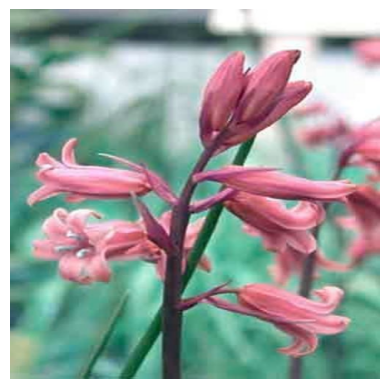

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


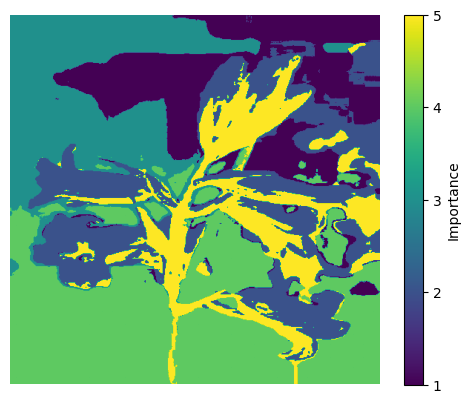

In [26]:
regionImportanceTester(1)

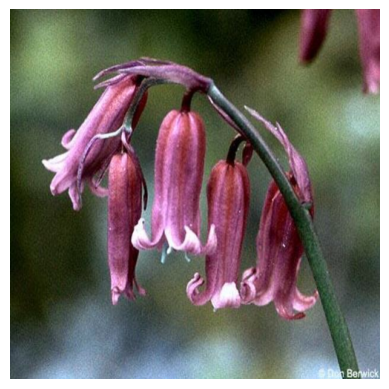

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


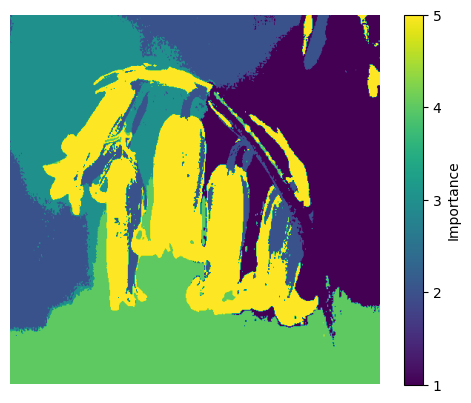

In [27]:
regionImportanceTester(15)

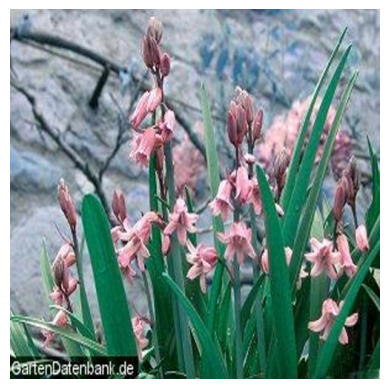

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


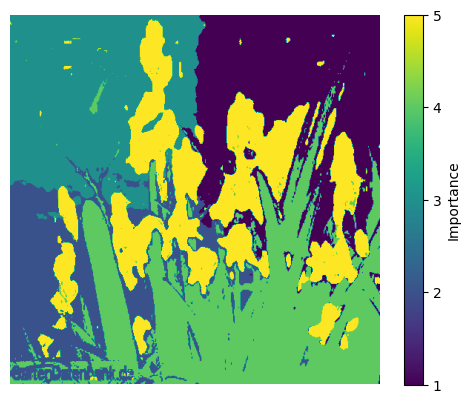

In [28]:
regionImportanceTester(50)

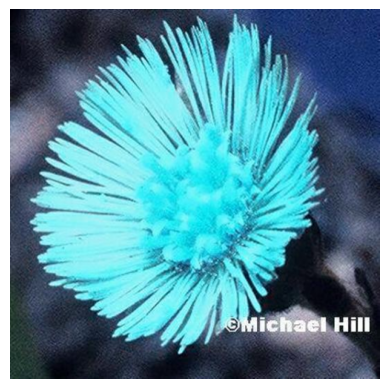

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


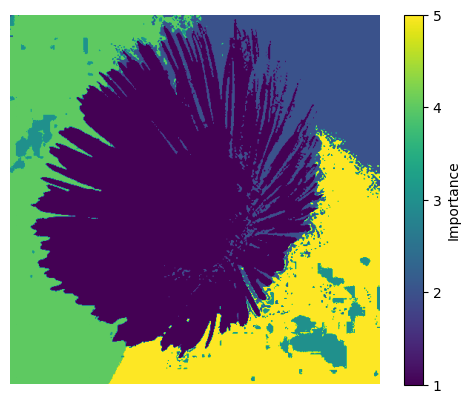

In [29]:
regionImportanceTester(100)

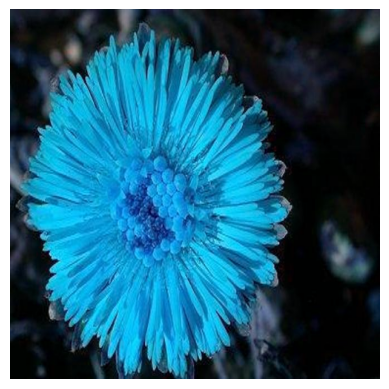

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


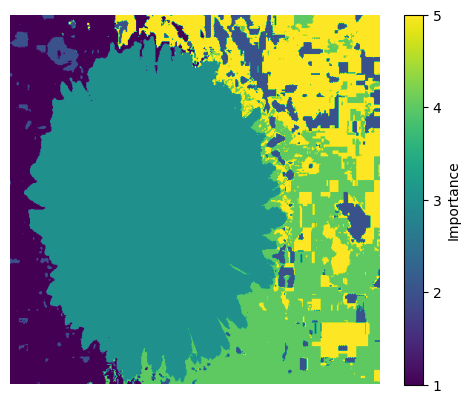

In [30]:
regionImportanceTester(102)

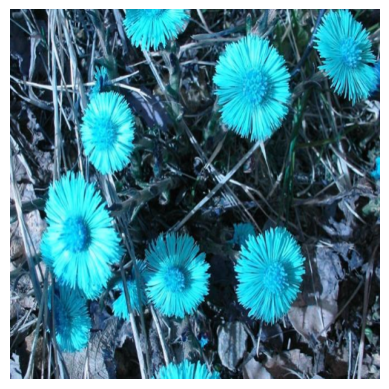

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


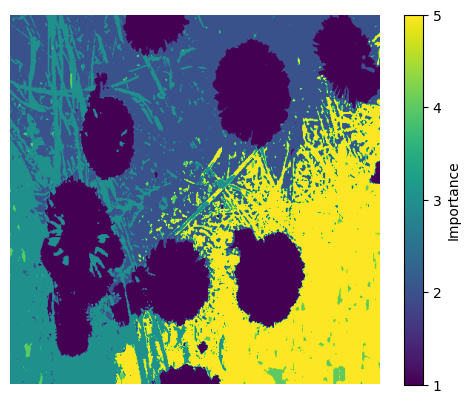

In [31]:
regionImportanceTester(156)

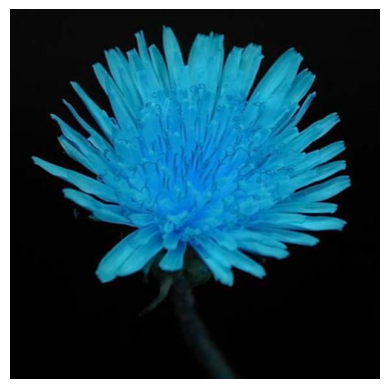

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


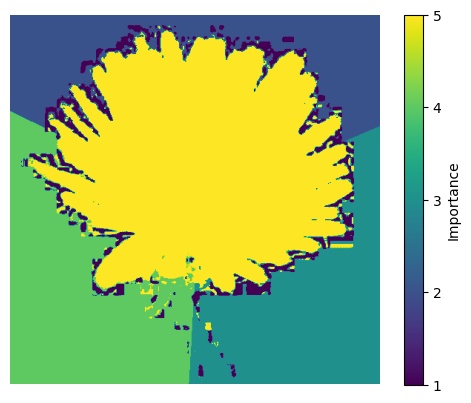

In [32]:
regionImportanceTester(200)

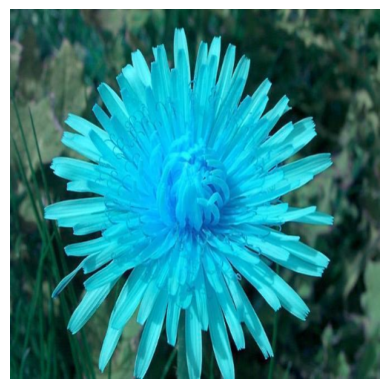

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


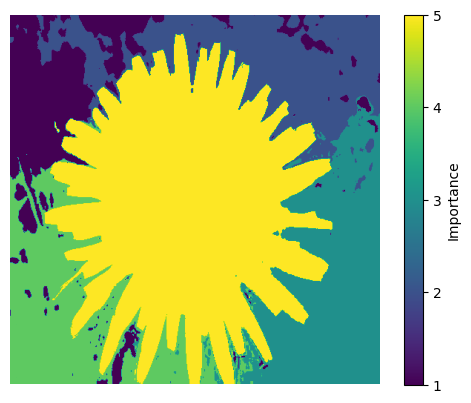

In [33]:
regionImportanceTester(201)

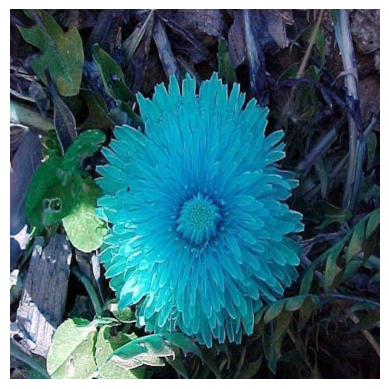

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


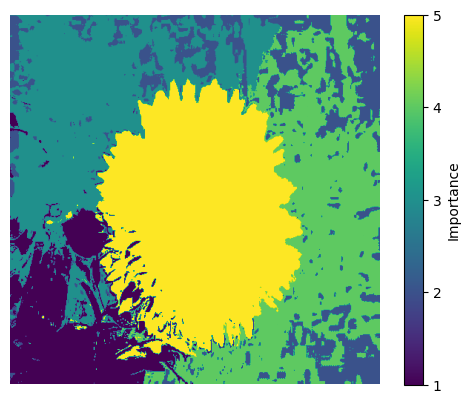

In [34]:
regionImportanceTester(204)

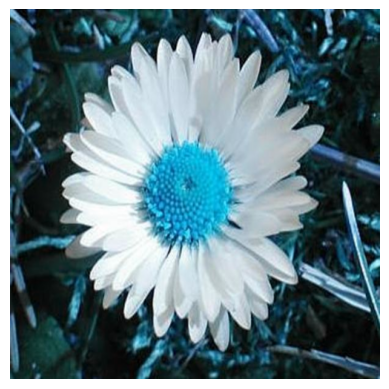

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


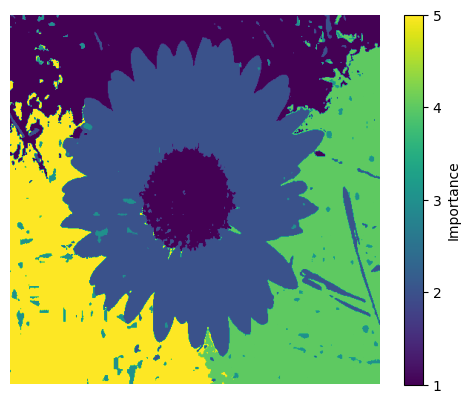

In [35]:
regionImportanceTester(257)

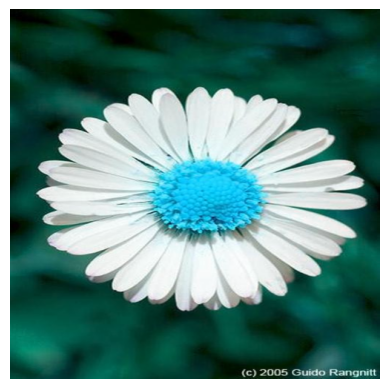

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


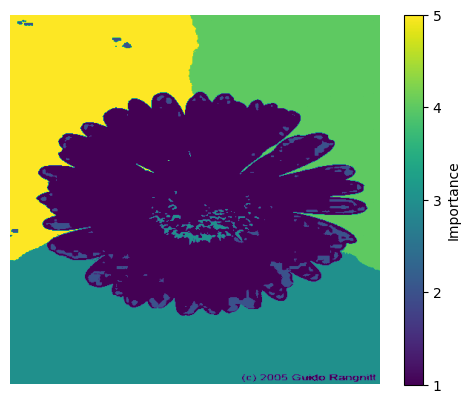

In [36]:
regionImportanceTester(270)

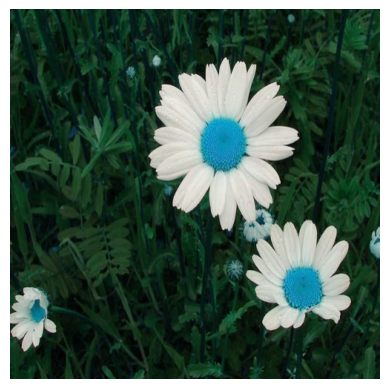

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


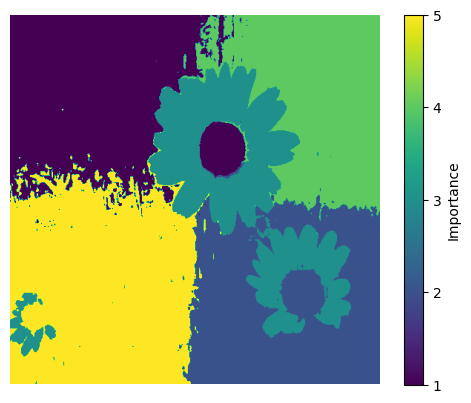

In [37]:
regionImportanceTester(310)

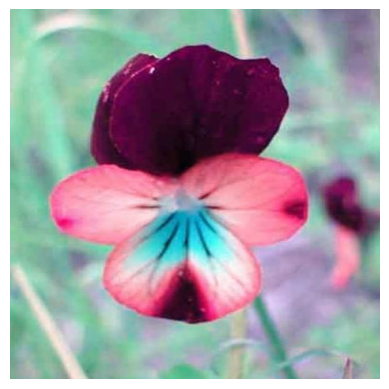

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


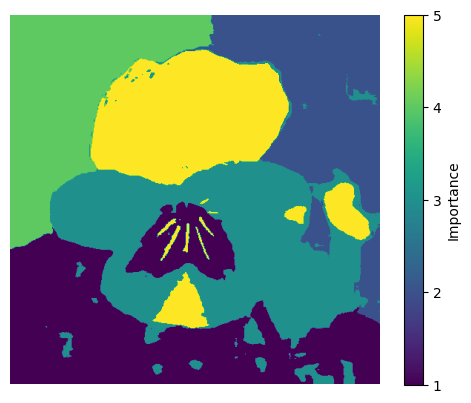

In [38]:
regionImportanceTester(350)

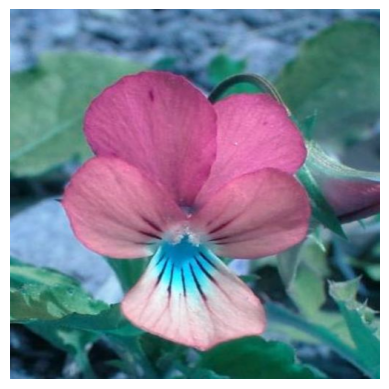

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


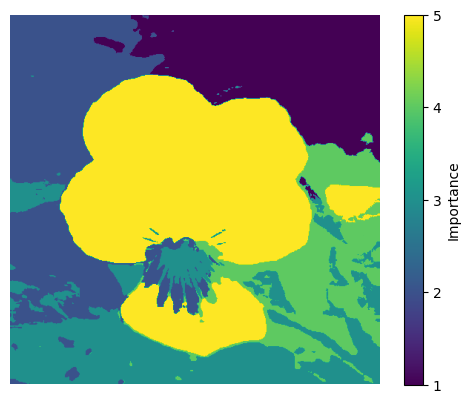

In [39]:
regionImportanceTester(351)

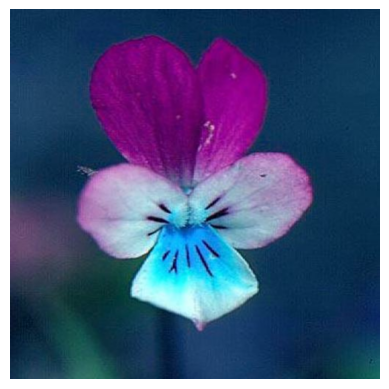

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


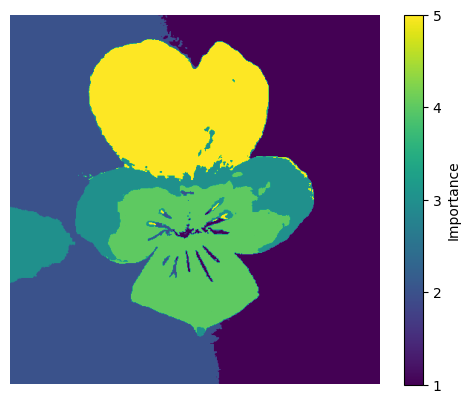

In [40]:
regionImportanceTester(352)

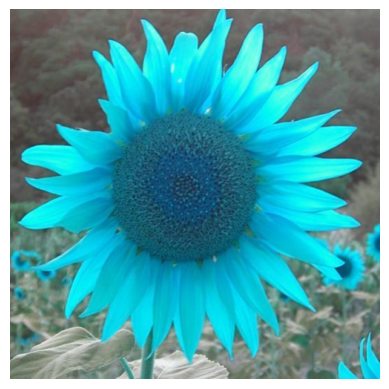

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


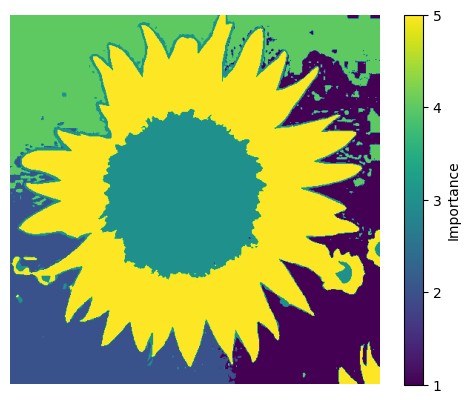

In [41]:
regionImportanceTester(400)

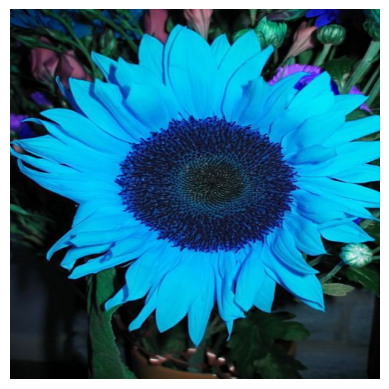

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


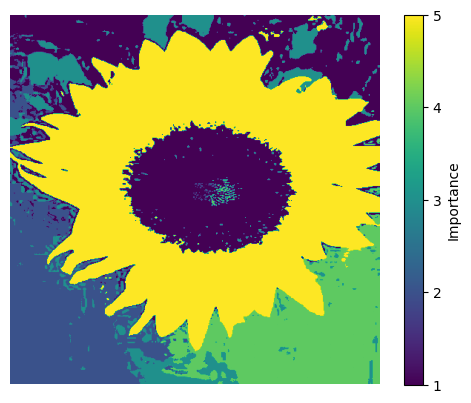

In [42]:
regionImportanceTester(402)

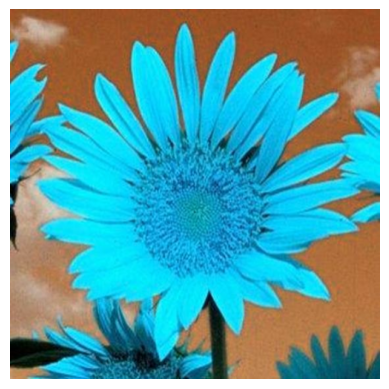

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


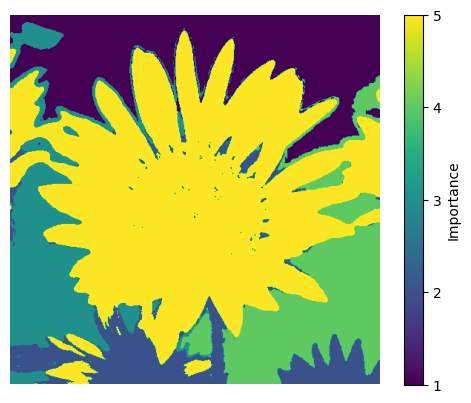

In [43]:
regionImportanceTester(450)

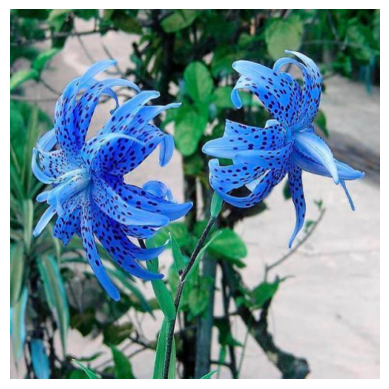

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


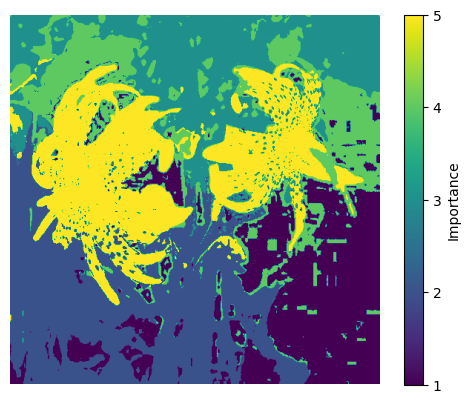

In [44]:
regionImportanceTester(501)

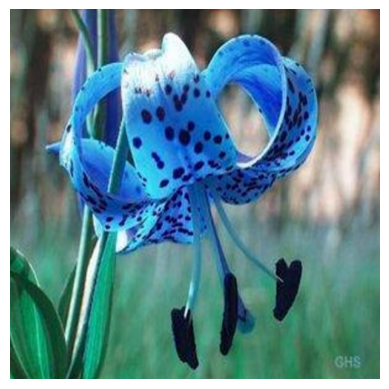

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


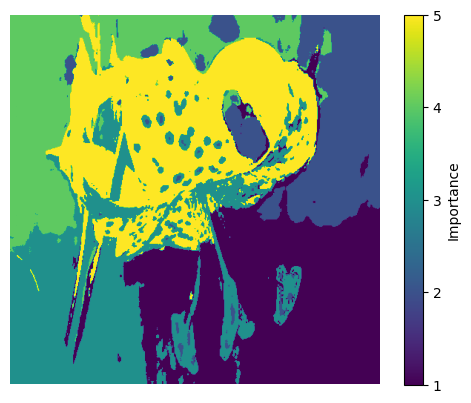

In [45]:
regionImportanceTester(503)

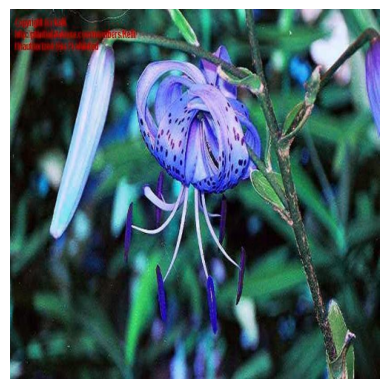

C:\Users\ASUS\AppData\Roaming\Python\Python39\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


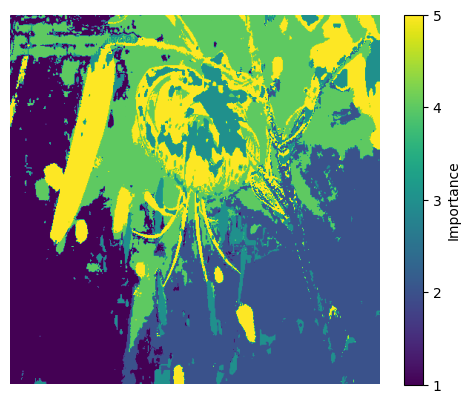

In [46]:
regionImportanceTester(540)